# How to Directly Access MERRA-2 Data from an S3 Bucket with Python
### Author: Chris Battisto, Alexis Hunzinger
### Date Modified: 9-23-22

### Timing

Exercise: 30 minutes

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>This notebook <em><strong>will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook demonstrates how to access and plot a Modern-Era Retrospective analysis for Research and Applications (MERRA-2) M2T1NXSLV.5.12.4 granule, and a Daymet Daily Precipitation granule hosted via an Amazon S3 bucket. It demonstrates how to access an S3 bucket with the S3FS library and plot sea-level pressure and precipitation contours with Cartopy and Matplotlib. 

### Prerequisites

This notebook was written using Python 3.8, and requires these libraries and files: 
- xarray
- cartopy
- matplotlib
- S3FS
  - S3FS documentation: https://s3fs.readthedocs.io/en/latest/install.html\
- netrc file with valid Earthdata Login credentials.
  - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- Approval to access the GES DISC archives with your Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login)


### Import Libraries

In [1]:
import requests
import xarray as xr
import s3fs
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
import pprint
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass

warnings.filterwarnings('ignore')
%matplotlib inline

### Generate .netrc file with your Earthdata Login credentials

This code generates a `.netrc` file in the `~/root/` directory of your JupyterHub space here. The `.netrc` files stores your Earthdata Login credentials, which are essential for access to GES DISC data and other NASA Earthdata collections. After you run this code cell, you will be prompted for your Earthdata Login Username and your Earthdata Login Password. Please enter them in the appropriate prompt box and press Enter.

Alternatively, you can upload a previously generated `.netrc` file to `~/root</` using the File Browser panel.



***Troubleshooting Tip***


> If you believe you have entered an incorrect username or password, you can open up a terminal instance by clicking the blue "plus" button in the top left corner, selecting "Terminal", and then remove the previously generated `.netrc` file by typing in `rm .netrc`. Then, this cell can be rerun to generate a new `.netrc` file.

In [2]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

In [6]:
! conda list

# packages in environment at /srv/conda/envs/notebook:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
affine                    2.3.1              pyhd8ed1ab_0    conda-forge
aiobotocore               2.3.3              pyhd8ed1ab_0    conda-forge
aiohttp                   3.8.1            py39hb9d737c_1    conda-forge
aioitertools              0.10.0             pyhd8ed1ab_0    conda-forge
aiosignal                 1.2.0              pyhd8ed1ab_0    conda-forge
alembic                   1.8.0              pyhd8ed1ab_0    conda-forge
anyio                     3.6.1            py39hf3d152e_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hb9d737c_2    conda-forge


### Obtain S3 URL from CMR

Our primary goal in this cell is to obtain the S3 URL of the granule we are interested in. The S3 URL indicates the location of the granule in S3 storage. There are several ways to obtain an S3 URL, or a list of S3 URLs. We recommend one of the following:
1. Using the "Download Data" option in [Earthdata Search](https://search.earthdata.nasa.gov/search?ff=Available%20from%20AWS%20Cloud&fdc=Goddard%2BEarth%2BSciences%2BData%2Band%2BInformation%2BServices%2BCenter%2B%2528GES%2BDISC%252) and selecting files from the "AWS S3 Access" tab
2. Using the CMR API to perform a collection and/or granule search
3. Using the GES DISC "Subset/Get Data" dialog box *(feature coming soon)*
4. Using knowledge of the structure of granule IDs and the S3 Bucket/Object Prefix of a particular collection

In the code cell below, we take advatange of (2), using the CMR API and some a priori knowledge about our collection of interest. This includes:
1. The URL for CMR granule search: https://cmr.earthdata.nasa.gov/search/granules
2. The concept ID for the MERRA-2 collection: `C1276812863-GES_DISC`
3. The date and time: `2019-03-13T00:00:00Z`


In [14]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules'

cmr_response = requests.get(cmr_url, 
                            params={
                                'concept_id': 'C1276812863-GES_DISC',
                                'temporal': '2019-03-13T00:00:00Z',
                                'page_size': 200,
                                },
                            headers={
                                'Accept': 'application/json'
                                }
                           )

# Save and print S3 URL

for link in cmr_response.json()['feed']['entry'][0]['links']:
    if link['href'].startswith('s3://'):
        s3_link = link['href']
        
print(s3_link)

s3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4


### Get S3 Credential

A temporary credential is required to access Earthdata directly from S3. Currently each NASA DAAC requires a different credential. We will specify the endpoint for the GES DISC credential in this code cell: https://data.gesdisc.earthdata.nasa.gov/s3credentials

Here we retrieve your S3 access credential and then define an S3 direct access file system handler with S3FS. 


***Troubleshooting Tip***

>If you receive an error after running this code cell, double-check that your Earthdata Login username and password are entered correctly in your `.netrc` file, or check that you can access the following URL: https://data.gesdisc.earthdata.nasa.gov


*NOTE: This credential expires after one hour, and the below code cell will need to be rerun if time expires.*

In [3]:
auth_link = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials

def begin_s3_direct_access(url: str=auth_link):
    print(auth_link)
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'])

gesdisc_fs = begin_s3_direct_access()

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(gesdisc_fs)

https://data.gesdisc.earthdata.nasa.gov/s3credentials


s3fs.core.S3FileSystem

### Open the File in Xarray as an S3 File System Object

First, check that the file itself is intact. By calling <code>fs.info()</code> with S3FS, we can see some of the metadata assigned to files uploaded to S3 buckets.

In [ ]:
gesdisc_fs.info(s3_link)

{'ETag': '"ab39493d3182642efbf610439b3d1d29-2"',
 'LastModified': datetime.datetime(2021, 3, 18, 23, 32, 5, tzinfo=tzutc()),
 'size': 415071782,
 'name': 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4',
 'type': 'file',
 'StorageClass': 'STANDARD',
 'VersionId': None,
 'ContentType': 'application/octet-stream'}

In [5]:
! cat ~/.netrc

machine urs.earthdata.nasa.gov
login cbattisto
password Jacketanalfridge!2020 


In order to open an S3 bucket file, or group of files in Xarray, <code>fs.open()</code> and <code>fs.glob()</code> must be used when calling their URLs in <code>xr.open_dataset()</code>.
Here, we open a single M2T1NXSLV.5.12.4 file and subset its sea-level pressure values at a particular time slice.

In [17]:
ds = xr.open_dataset(gesdisc_fs.open(s3_link),
                     decode_cf=True,)

"""
To open a list of S3 URLs, use the following operation:

ds = xr.open_mfdataset([fs.open(f) for f in your_file_list])
"""

# Subset SLP at 15:30Z, convert units
slp = ds.SLP.values[15,:,:] / 100 # convert to hPa

slp

array([[ 985.77765,  985.77765,  985.77765, ...,  985.77765,  985.77765,
         985.77765],
       [ 985.1326 ,  985.1326 ,  985.1326 , ...,  985.13763,  985.13763,
         985.1326 ],
       [ 983.9426 ,  983.9377 ,  983.9377 , ...,  983.95264,  983.94763,
         983.94763],
       ...,
       [1007.2477 , 1007.26013, 1007.27014, ..., 1007.21014, 1007.22266,
        1007.23517],
       [1007.67017, 1007.6752 , 1007.6777 , ..., 1007.65765, 1007.66266,
        1007.66516],
       [1007.97766, 1007.97766, 1007.97766, ..., 1007.97766, 1007.97766,
        1007.97766]], dtype=float32)

### Plot Sea-Level Pressure Contours

Now that the file is inside a local Xarray dataset, we can perform any data analysis methods desired, such as plotting with Matplotlib.

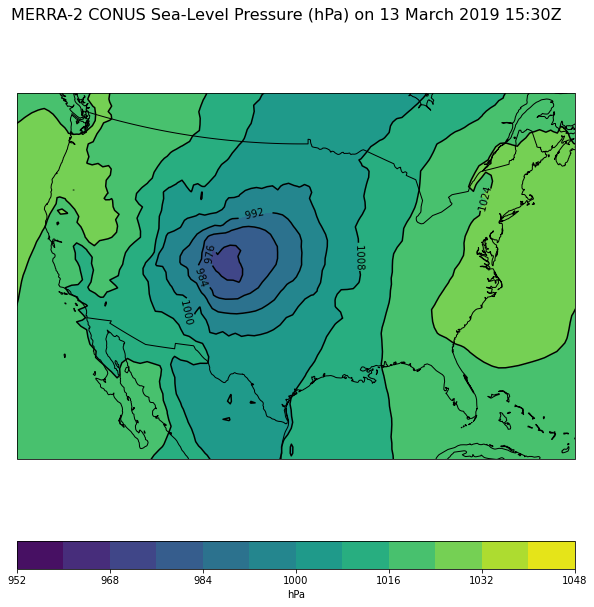

In [18]:
plt.rcParams['figure.figsize'] = 10,10

# Set up figure
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-121, -72, 23, 51], crs=ccrs.PlateCarree()) # CONUS extent
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)

# Set up filled and line contours
filled_c = ax.contourf(ds.lon, ds.lat, slp, levels=10, 
                       transform=ccrs.PlateCarree())
line_c = ax.contour(ds.lon, ds.lat, slp, levels=10,
                        colors=['black'],
                        transform=ccrs.PlateCarree())

# Set up labelling for contours
ax.clabel(line_c,  
    colors=['black'],
    manual=False,  
    inline=True,  
    fmt=' {:.0f} '.format,  
    )

# Set up colorbar and figure title
fig.colorbar(filled_c, orientation='horizontal', label='hPa')
fig.suptitle('MERRA-2 CONUS Sea-Level Pressure (hPa) on 13 March 2019 15:30Z', fontsize=16)

plt.show()

## **BONUS CONTENT**

## Cross-DAAC Data Access

Now we will obtain a granule from another NASA DAAC - in this case, a Daymet Daily Precipitation granule from our friends at ORNL DAAC. As mentioned above, this requires us to obtain an S3 credential specific to ORNL DAAC. 

This time we opted to use [Earthdata Search](https://search.earthdata.nasa.gov/search/granules?p=C2031536952-ORNL_CLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&q=daymet&ff=Available%20from%20AWS%20Cloud&tl=1663951986.625!3!!) to obtain the S3 URL for this particular Daymet Daily Precipitation file for our date and region of interest (March 13, 2019; CONUS).

In [19]:
# S3 URL for our Daymet granule of interest
s3_link = 's3://ornl-cumulus-prod-protected/daymet/Daymet_Daily_V4/data/daymet_v4_daily_na_prcp_2019.nc'

# ORNL S3 Credential URL
auth_link = "https://data.ornldaac.earthdata.nasa.gov/s3credentials"

# Calling our defined function from above to begin using S3 direct access file system handler
ornl_fs = begin_s3_direct_access(auth_link)

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
type(ornl_fs)

https://data.ornldaac.earthdata.nasa.gov/s3credentials


s3fs.core.S3FileSystem

Again use Xarray's `open_dataset()` function to read the granule and store it as an Xarray dataset.

In [20]:
ds = xr.open_dataset(ornl_fs.open(s3_link),
                     decode_cf=True,)

ds

<xarray.Dataset>
Dimensions:                  (x: 7814, y: 8075, time: 365, nv: 2)
Coordinates:
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2019-01-01T12:00:00 ... 20...
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 ...
Attributes:
    start_year:        2019
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...

Finally, plot the total precipiation amount on March 13, 2019 over CONUS!

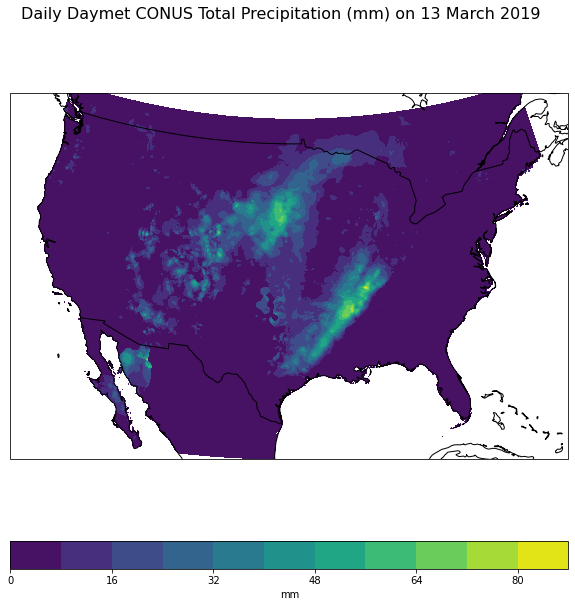

In [21]:
mask_lon = (ds.lon >= -125) & (ds.lon <= -67)
mask_lat = (ds.lat >= 23) & (ds.lat <= 51)

ds_sel = ds.sel(time=ds['time'][71]).where(mask_lon & mask_lat, drop=True)

plt.rcParams['figure.figsize'] = 10,10

# Set up figure
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-121, -72, 23, 51], crs=ccrs.PlateCarree()) # CONUS extent
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)

# Set up filled and line contours

filled_c = ax.contourf(ds_sel.lon, ds_sel.lat, ds_sel.prcp, levels=10, 
                       transform=ccrs.PlateCarree())

# Set up colorbar and figure title
fig.colorbar(filled_c, orientation='horizontal', label='mm')
fig.suptitle('Daily Daymet CONUS Total Precipitation (mm) on 13 March 2019', fontsize=16)

plt.show()

In [1]:
! conda install -c conda-forge earthaccess -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - earthaccess


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aiofiles-22.1.0            |     pyhd8ed1ab_0          17 KB  conda-forge
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    earthaccess-0.4.7          |     pyhd8ed1ab_0          48 KB  conda-forge
    libmagic-5.39              |       h753d276_1         294 KB  conda-forge
    multimethod-1.9            |     pyhd8ed1ab_0          13 KB  conda-forge
    openssl-1.1.1s             |       h0b41bf4_1         1.9 MB  conda-fo